# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цель исследования:**
выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости.

**Ход исследования**
Данные мы получим из файла /datasets/real_estate_data.csv О качестве данных ничего не известно. Поэтому прежде всего понадобится обзор данных.

Исследование пройдёт в пять этапов:

1) Открытие файла с данными и изучение общей информации.
2) Предобработка данных (работа с пропусками, дубликатами, аномалиями, в случае необходимости - преобразование типов данных).
3) Добавление в таблицу новых столбцов с недостающими параметрами (цена 1м2, день недели, месяц и год публикации объявления, тип этажа квартиры и расстояние до центра города в км.).
4) Проведение исследовательского анализа данных.
5) Общие выводы.

### Открываем файл с данными и изучаем общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

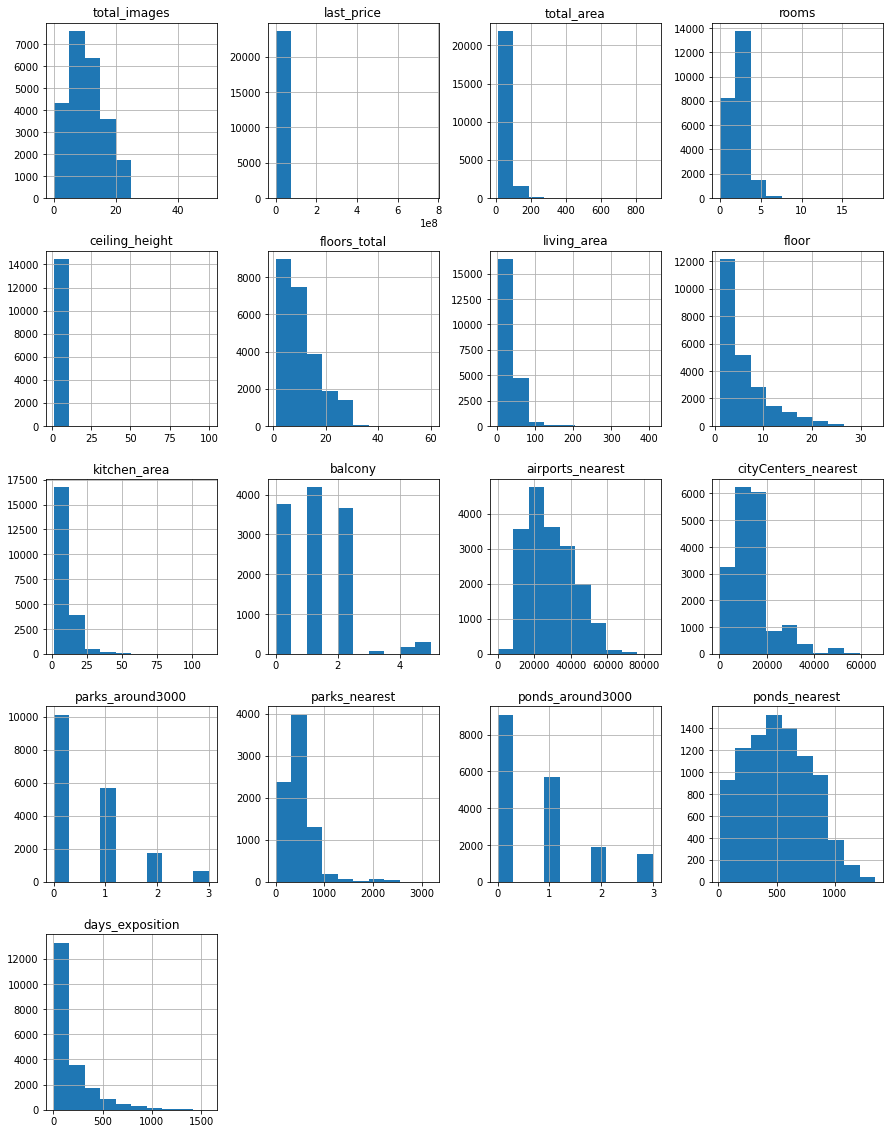

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.info()
df.hist(figsize=(15,20));

23699 записей, 22 столбца. Количество цифровых столбцов 17 (соответствует действительности, преобразовывать нет необходимости)
По гистограммам числовых столбцов можно сделать предварительные выводы:
- большая часть квартир имеет от 5 до 20 фото.
- основная масса квартир с площадью до 100м2
- преобладают квартиры одно-, двух- и 3-х комнатные квартиры
- лидируют 5-6-этажные дома, далее идут дома до 12 этажей
- преобладают квартиры с жилой площадью до 40кв.м.
- преобладают квартиры с 1 по 4 этаж
- площадь кухни - до 12м2
- квартиры в основном продаются 4 месяца

### Предобработка данных

In [2]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


In [3]:
# Последовательно меняя названия столбцов в коде ниже, проанализируем имеющиеся пропуски и причины
# их возникновения.
# print(df[df['ceiling_height'].isna()].head(10))
# Заменим пропуски числа балконов (связаны с тем, что их нет) на 0
df['balcony'] = df['balcony'].fillna(0).astype('int')
# Заменим пропуски по числу парков в радиусе 3км (связаны с тем, что их нет) на 0
df['parks_around3000'] = df['parks_around3000'].fillna(0).astype('int')
# Заменим пропуски по числу водоёмов в радиусе 3км (связаны с тем, что их нет) на 0
df['ponds_around3000'] = df['ponds_around3000'].fillna(0).astype('int')
# Удалим строки при наличии пропуска в столбце названия населённого пункта 'locality_name'
# (всего 49 строк из 23699, можно смело идалить)
df = df.dropna(subset=['locality_name'])
# Т.к. пропуски в столбце "всего этажей в доме" ('floors_total') вызваны тем, что этаж последний,
#  заменим их значением из столбца 'floor'
df['floors_total'] = df['floors_total'].fillna('floors')
# 85 строк имеют значение "floors". Также примем, что это последний этаж
df.loc[df['floors_total'] == 'floors','floors_total'] = df['floor']
# "Аппартаменты" Если в столбце NaN - меняем на False
df['is_apartment'] = df['is_apartment'].fillna(False)
# Заполним пропуски в жилой площади медианным значением
df.loc[df['living_area'].isna(),'living_area'] = (df['total_area'] * df['living_area'].median()
     / df['total_area'].median())
# Проверяем:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23650 non-null  object 
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               23650 non-null  int64  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Остались пропуски в столбцах:
- Расстояние до аэропорта
- Расстояние до центра города
- Расстояние до ближайшего парка
- Расстояние до ближайшего водоёма
    Это картографические данные. Оставим пока данные пропуски, возможно, они не понадобятся нам при анализе.
- Высота потолков. Пока оставим пропуски.
- Сколько дней было размещено объявление до снятия - наличие пропуска означает, что объявление не снято с публикации. Оставим пропуск.
- Площадь кухни. Пропуск может быть вызван либо отсутствием кухни (коммуналка, аппартаменты, студия, перепланировка), либо не добавленной информацией пользователем. Оставим пропуски.
- Жилая площадь. Причины возникновения пропусков - аналогичны пропускам в Площади кухни. данные пропуски заменим медианным значением, исходя из общей площади квартиры.

In [4]:
# Преобразуем данные столбца с датой и временем в соответствующий тип
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

In [5]:
# Работаем с дубликатами.
df.duplicated().sum()
df = df.drop_duplicates()
df.shape[0]
# явных дубликатов неn
# Выявим неявные дыбликаты:
# print(df['locality_name'].unique())
# Устраним неявные дубликаты:
duplicates = ['посёлок', "городской", "деревня", "поселок", "городского типа", "садовое",
              "товарищество", "некоммерческое", "село", "станции", "при железнодорожной",
               "коттеджный", "садоводческое"]
def reset_duplicates(text):
    for word in duplicates:
        text = text.replace(word, '').strip()
    return text
            
df['locality_name'] = df['locality_name'].apply(reset_duplicates)
print(sorted(df['locality_name'].unique()))

['Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро', 'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров', 'Бокситогорск', 'Большая Вруда', 'Большая Ижора', 'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино', 'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь', 'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Вещево', 'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово', 'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг', 'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово', 'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево', 'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово', 'Дзержинского', 'Дружная Горка', 'Дружноселье', 'Дубровка', 'Елизаветино', 'Ефимовский', 'Жил', 'Жилгородок', 'Житково', 'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск', 'Зимитицы', 'Ивангород', 'Извара', 'Ильичёво', 'Иссад', 'Калитино', 'Каложицы', 'Кальтино', 'Каменногорск', 'Камышовка', 'Каськово', 'Келози', '

In [6]:
# Устраняем редкие, ошибочные, выбивающиеся значения в высоте потолков:
#df = df.replace({'ceiling_height':{100:10, 32:3.2, 27.5:2.75, 27:2.7, 26:2.6, 25:2.5, 24:2.4,
#                                    22.6:2.26, 20:2}})

# Функция для исправления ошибок и округления до десятых в данных объявлений:
def data_error(data):
    if data >= max_param:
        data = round(data / 10, 1)
    return data

max_param = 20
df['ceiling_height'] = df['ceiling_height'].apply(data_error).round(1)

In [7]:
print(sorted(df['ceiling_height'].unique()))

[2.7, nan, 1.0, 1.2, 1.8, 2.0, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.2, 5.3, 5.5, 5.6, 5.8, 6.0, 8.0, 8.3, 10.0, 10.3, 14.0]


In [8]:
# Устраняем редкие, ошибочные, выбивающиеся значения в общей площади:
# df = df.replace({'total_area':{590.0:59, 618.0:61.8, 631.0:63.1, 631.2:63.12, 900.0:90}})
max_param = 520
df['total_area'] = df['total_area'].apply(data_error).round(1)

In [9]:
# Преобразуем данные остальных столбцов в соответствующий тип
df['last_price'] = df['last_price'].astype('int')
df['floors_total'] = df['floors_total'].astype('int')
df['living_area'] = df['living_area'].round(1)

In [10]:
# Обновим индексацию датафрейма
df = df.reset_index(drop=True)

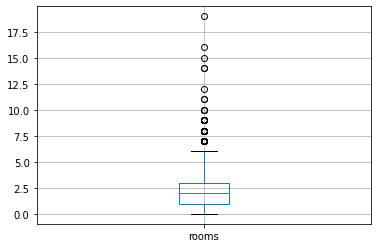

In [11]:
# Изучим датасет на предмет количества комнат
# print(sorted(df['rooms'].unique()))
df.boxplot('rooms');

Из диаграммы размаха видим, что в объявлениях в основном представлены помещения с количеством комнат до шести.
Медианное значение - две комнаты. Присутствуют "выбросы" - где до 19 комнат.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        14490 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          21381 non-null  float64       
 13  balcony         

Какие особенности в данных обнаружены, и какие действия были предприняты:
- в колонке с количеством балконов были пропуски. Приняли - что в данном случае балкона нет (заменили пропуски на 0)
- были пропуски в числе парков в радиусе 3км. Приняли, что в этом случае парка нет, поставили 0
- были пропуски в числе парков в радиусе 3км. Приняли, что в этом случае парка нет, поставили 0
- были пропуски в количестве водоёмов в радиусе 3км. Приняли, что в этом случае его нет, поставили 0
- удалили строки при наличии пропуска в столбце названия населённого пункта 'locality_name' (49 строк из 23699)
- пропуски, а также значения 'floor' в столбце "всего этажей в доме" ('floors_total') вызваны тем, что этаж последний, заменили их значением из столбца 'floor'
- в столбце "Аппартаменты" значения NaN заменили на False
- у столбцов 'first_day_exposition' и 'floors_total' преобразовали тип данных.
- устранили неявные дубликаты в столбце 'locality_name'
- устранили редкие, ошибочные, выбивающиеся значения в высоте потолков и в общей площади
- заменили имеющиеся пропуски в жилой площади квартиры медианным значением, исходя из общей площади квартиры.
- обнаружены квартиры с высотой пололков до 10 метров - это какие-то аномалии
- обнаружены квартиры площадью до 500м2, количество комнат достигает 19. Это также является какими-то аномалиями.

### Посчитаем и добавим в таблицу новые столбцы

In [13]:
# Рассчитаем цену 1м2
df['one_square_price'] = df['last_price'] / df['total_area']
# День недели публикации объявления (0-пн, 1-вт, 2-ср. и т.д.)
df['weekday'] = df['first_day_exposition'].dt.weekday
# Месяц публикации объявления
#df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['month'] = df['first_day_exposition'].astype('datetime64[M]')
# Год публикации объявления
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year
# Тип этажа квартиры
def type_floors(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['floor_type'] = df.apply(type_floors, axis=1)
# Расстояние до центра в км.
df['distance_center_km'] = round(df['cityCenters_nearest'] / 1000)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_square_price,weekday,month,year,floor_type,distance_center_km
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,482.0,2,755.0,NaN,120370.370370,3,2019-03-01,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,NaN,0,NaN,81.0,82920.792079,1,2018-12-01,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,90.0,2,574.0,558.0,92785.714286,3,2015-08-01,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,NaN,14,91.7,9,False,...,84.0,3,234.0,424.0,408176.100629,4,2015-07-01,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.0,14,32.0,13,False,...,112.0,1,48.0,121.0,100000.000000,1,2018-06-01,2018,другой,8.0


In [14]:
# Посмотрим, за какие годы в нашем датасете присутствуют объявления:
df.groupby('year')['year'].count()

year
2014     136
2015    1173
2016    2765
2017    8185
2018    8512
2019    2879
Name: year, dtype: int64

### Проведём исследовательский анализ данных

**Гистограмма "Распределение типа этажности по объявлениям":**

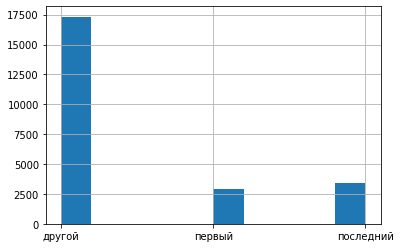

In [15]:
df['floor_type'].hist();

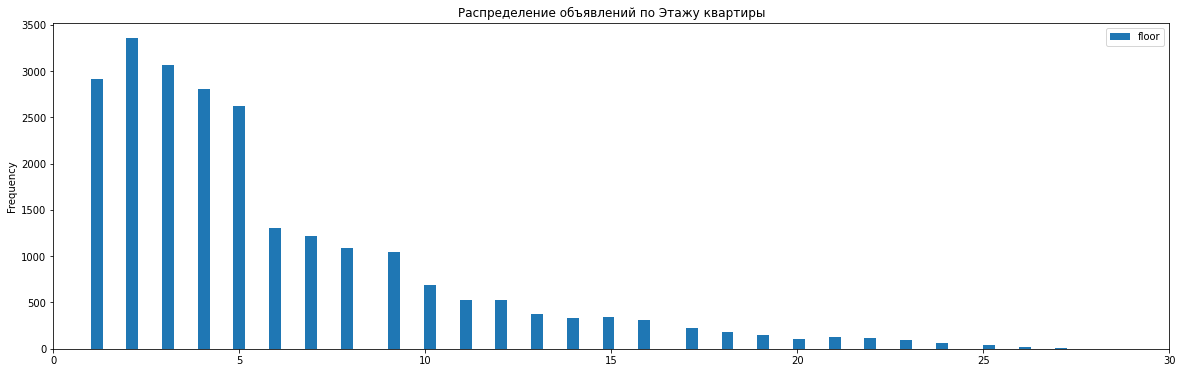

In [16]:
df.plot(y='floor', kind='hist',  bins=100, xlim=(0,30), figsize=(20,6),
        title="Распределение объявлений по Этажу квартиры");

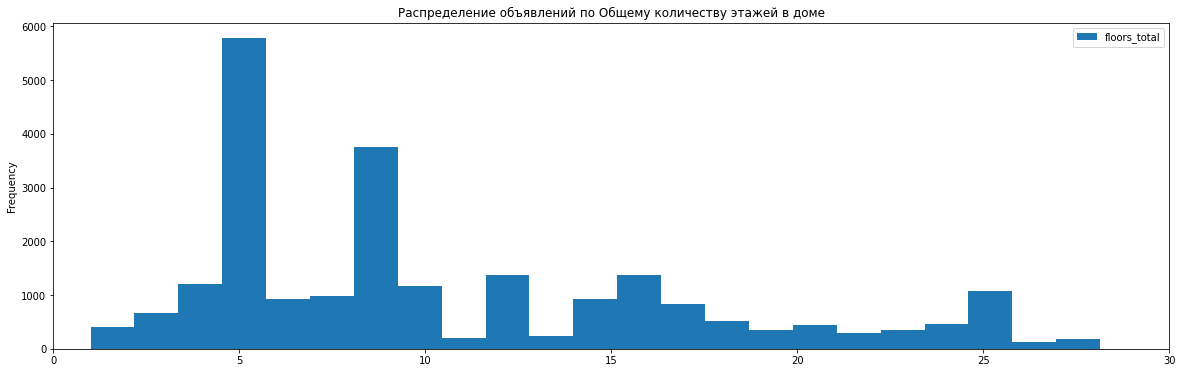

In [17]:
df.plot(y='floors_total', kind='hist', bins=50, xlim=(0,30), figsize=(20,6),
        title="Распределение объявлений по Общему количеству этажей в доме");

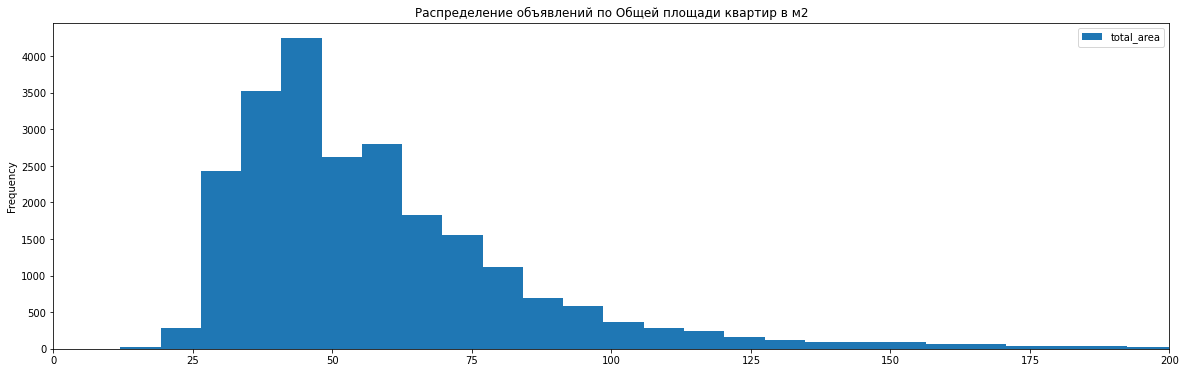

In [18]:
df.plot(y='total_area', kind='hist', bins=70, xlim=(0,200), figsize=(20,6),
        title="Распределение объявлений по Общей площади квартир в м2");

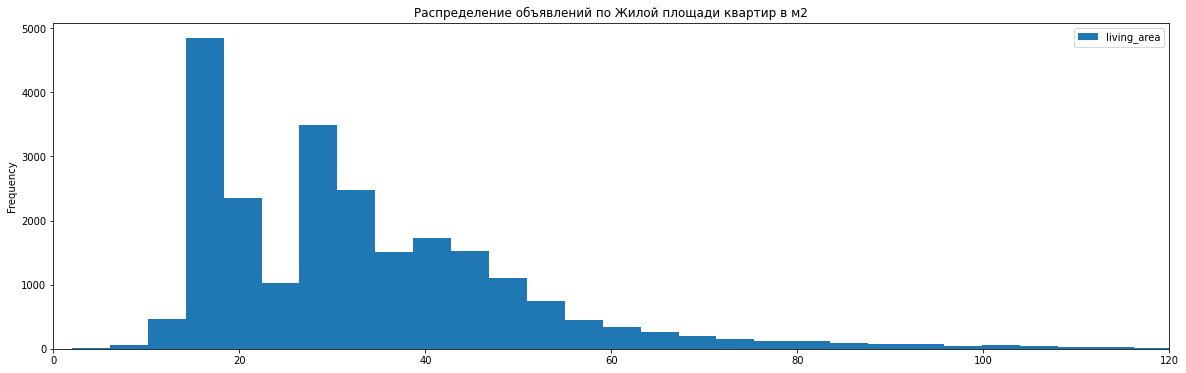

In [19]:
df.plot(y='living_area', kind='hist', bins=100, xlim=(0,120), figsize=(20,6),
        title="Распределение объявлений по Жилой площади квартир в м2");

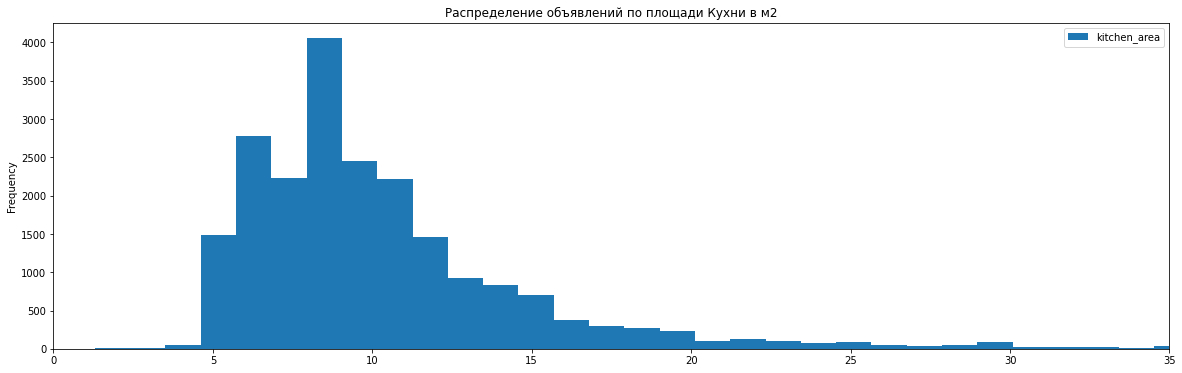

In [20]:
df.plot(y='kitchen_area', kind='hist', bins=100, xlim=(0,35), figsize=(20,6),
        title="Распределение объявлений по площади Кухни в м2");

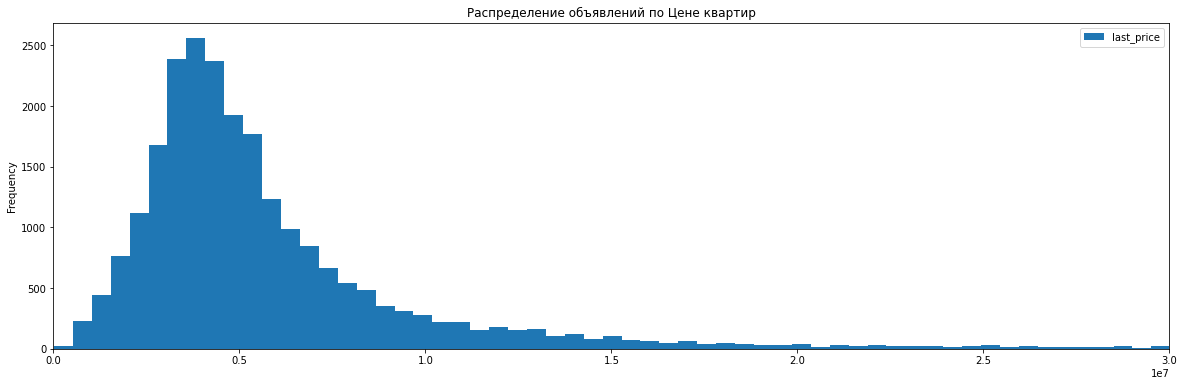

In [21]:
df.plot(y='last_price', kind='hist', bins=1500, xlim=(0,30000000), figsize=(20,6),
        title="Распределение объявлений по Цене квартир");

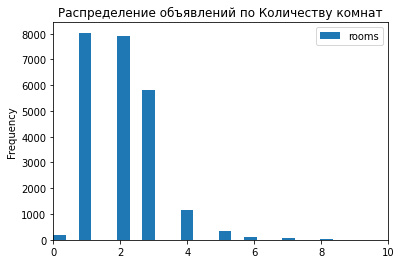

In [22]:
df.plot(y='rooms', kind='hist',  bins=50, xlim=(0,10),
        title="Распределение объявлений по Количеству комнат");

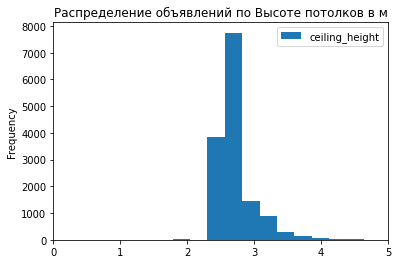

In [23]:
df.plot(y='ceiling_height', kind='hist', bins=50, xlim=(0,5),
        title="Распределение объявлений по Высоте потолков в м");

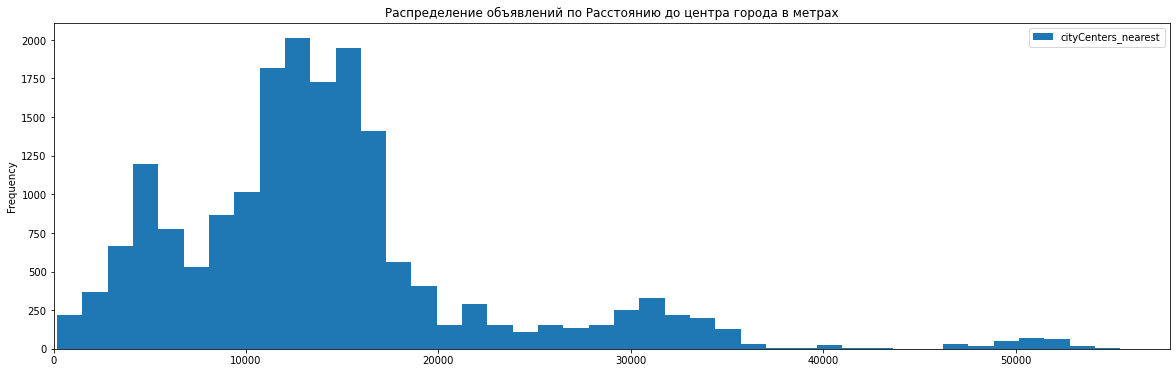

In [24]:
df.plot(y='cityCenters_nearest', kind='hist', bins=50, xlim=(0,58000), figsize=(20,6),
        title="Распределение объявлений по Расстоянию до центра города в метрах");

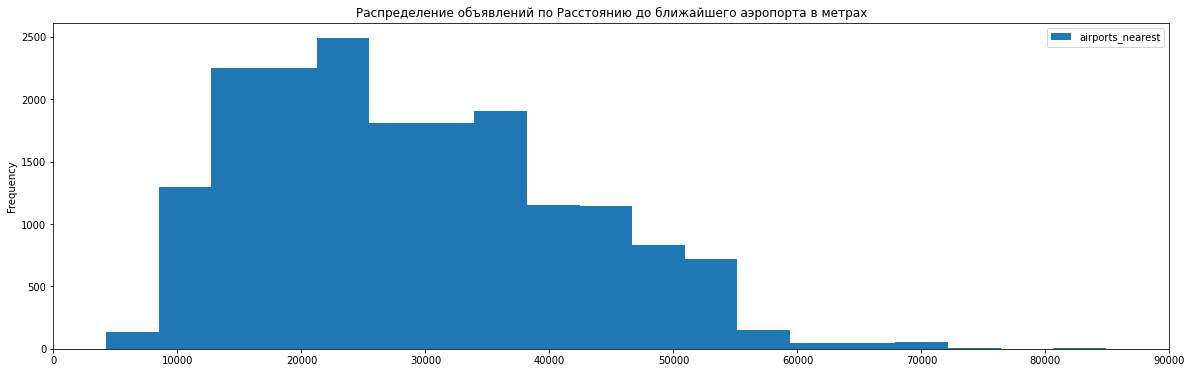

In [25]:
df.plot(y='airports_nearest', kind='hist', bins=20, xlim=(0,90000), figsize=(20,6),
        title="Распределение объявлений по Расстоянию до ближайшего аэропорта в метрах");

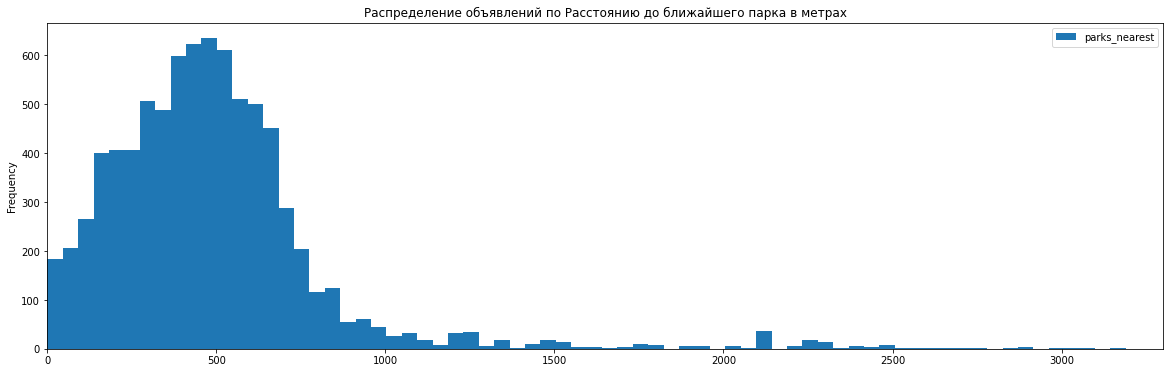

In [26]:
df.plot(y='parks_nearest', kind='hist', bins=70, xlim=(0,3300), figsize=(20,6), title=
        "Распределение объявлений по Расстоянию до ближайшего парка в метрах");

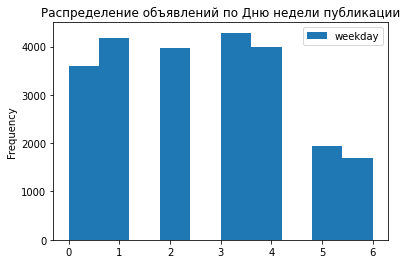

In [27]:
df.plot(y='weekday', kind='hist', title="Распределение объявлений по Дню недели публикации");

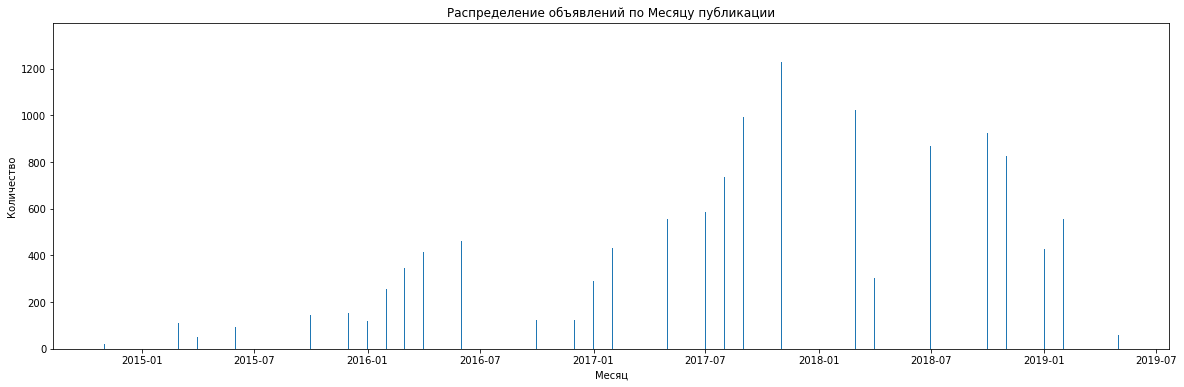

In [28]:
#df.plot(y='month', kind='hist', bins=30, sharex=False, title="Распределение объявлений по Месяцу публикации");
month_count = df['month'].value_counts()
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 6))
plt.bar(month_count.index, month_count)
plt.title(label="Распределение объявлений по Месяцу публикации")
plt.xlabel("Месяц")
plt.ylabel("Количество")

plt.show()




**Выводы по гистограммам:**
- большая доля продающихся квартир - на средних этажах. Основная масса квартир - на 2-м этаже, далее лидируют 1-й и с 3 по 5 этажи.
- самые продаваемые квартиры - в пятиэтажках, далее идут девятиэтажные дома.
- популярная площадь квартиры: 27-63м2 с пиком на 45м2
- по жилой площади - лидеры 18м2, далее идут квартиры с 30м2
- по площади кухни лидерство занимает 9м2, далее идут квартиры с кухней 6м2
- в ценовом диапазоне лидируют квартиры от 2,5 до 6 миллионов рублей
- по количеству комнат лидируют одно, двух и трёхкомнатные квартиры
- квартиры в основном имеют высоту потолков 2,7-2,4 метра
- продаваемое жильё располагается в основном на расстоянии 11-17км от центра. Также присутствует достаточно квартир на удалении 3-6 км. от центра
- в основном жильё находится в 12-38 км. от Аэропорта, до ближайшего парка: 200-700 метров.
- пик активности в размещении объявлений о продаже квартир наблюдается по вторникам и четвергам, в выходные-же - наоборот, минимальная активность.
- по месяцам - наибольшая активность наблюдается с февраля по апрель. В мае - резкий спад. Далее, и июня по ноябрь - почти стабильный рост.

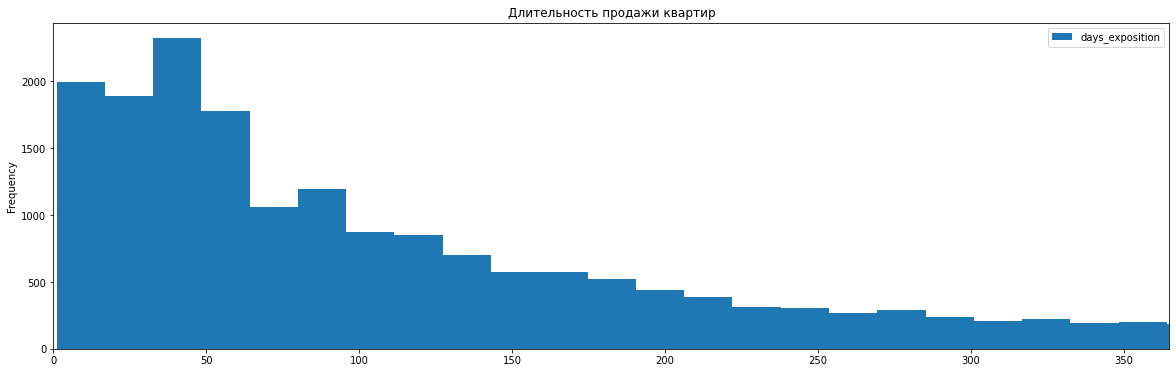

In [29]:
df.plot(y='days_exposition', kind='hist', bins=100, xlim=(0,365), figsize=(20,6),
        title="Длительность продажи квартир");

In [30]:
df['days_exposition'].describe()

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

- Среднее время продажи квартиры - пол-года.
- Медианное время продажи - 95 дней (3 месяца).
- Реальное ("Межквартильное") время продажи квартиры - от 45 до 231 дня (1,5-7,5 месяцев)
- "Быстрой" считается продажа квартиры за 1,5 месяца, а "долгой" - 7,5 месяцев.

In [31]:
# Построим матрицу корреляции
df.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_square_price,weekday,year,distance_center_km
total_images,1.000000,0.104558,0.115422,0.099660,0.044914,0.010548,0.101870,0.030832,0.010512,-0.029389,...,-0.047835,0.036990,-0.008158,0.011077,-0.003424,-0.027415,0.105725,-0.010510,0.140884,-0.047298
last_price,0.104558,1.000000,0.599395,0.363421,0.346260,-0.006762,0.585932,0.026770,0.026964,-0.025363,...,-0.206887,0.197704,-0.016310,0.208842,-0.085193,0.080937,0.738827,0.001607,-0.042927,-0.207140
total_area,0.115422,0.599395,1.000000,0.758143,0.423335,-0.077652,0.924919,-0.027977,0.030864,-0.074847,...,-0.236178,0.208445,-0.022784,0.203211,-0.097022,0.155102,0.218379,-0.004005,-0.084815,-0.236009
rooms,0.099660,0.363421,0.758143,1.000000,0.250947,-0.226896,0.827176,-0.150604,0.000422,-0.147371,...,-0.184322,0.157095,-0.054236,0.121450,-0.058705,0.126497,0.094675,-0.004316,-0.054641,-0.183842
ceiling_height,0.044914,0.346260,0.423335,0.250947,1.000000,-0.076997,0.391929,-0.036479,0.084806,0.016667,...,-0.314306,0.255510,-0.053493,0.231826,-0.134858,0.112738,0.235617,-0.010768,-0.096770,-0.314507
floors_total,0.010548,-0.006762,-0.077652,-0.226896,-0.076997,1.000000,-0.158467,0.678060,-0.026345,0.069591,...,0.018382,-0.158492,0.097051,-0.049201,0.040189,-0.052773,0.109214,0.012543,0.008477,0.017701
living_area,0.101870,0.585932,0.924919,0.827176,0.391929,-0.158467,1.000000,-0.088836,0.028875,-0.056501,...,-0.229748,0.208232,-0.048680,0.183922,-0.084841,0.143276,0.282719,-0.003853,-0.071384,-0.229399
floor,0.030832,0.026770,-0.027977,-0.150604,-0.036479,0.678060,-0.088836,1.000000,-0.013321,0.036978,...,0.008508,-0.104945,0.073157,-0.029920,0.025923,-0.039501,0.102522,0.011746,0.005273,0.008018
is_apartment,0.010512,0.026964,0.030864,0.000422,0.084806,-0.026345,0.028875,-0.013321,1.000000,-0.003665,...,0.003699,0.021581,-0.033422,0.024467,0.003344,0.015303,0.032187,-0.009488,0.009313,0.003522
studio,-0.029389,-0.025363,-0.074847,-0.147371,0.016667,0.069591,-0.056501,0.036978,-0.003665,1.000000,...,-0.007093,-0.032055,0.009132,-0.009656,0.002587,-0.022447,0.010716,-0.000818,0.011775,-0.007534


В результате анализа матрицы корреляции, можно сделать выводы о влиянии на общую стоимость объекта last_price следующих параметров:
- total_area (общая площадь) - коэффициент 0,6 положительный, большой (сильное влияние на цену).
- living_area (жилая площадь) - коэффициент 0,6 положительный, большой (сильное влияние на цену).
- kitchen_area (площадь кухни) - коэффициент 0,5 положительный, большой (сильное влияние на цену).

В меньшей степени, но также оказывают влияние:
- rooms (количество комнат) - коэффициент 0,4.
- ceiling_height (высота потолков) - коэффициент 0,35.
- parks_around3000 (количество парков в радиусе 3км) - коэффициент 0,2.
- ponds_around3000 (количество парков в радиусе 3км) - коэффициент 0,2.
- cityCenters_nearest (расстояние до центра города) - отрицательный коэффициент -0,2

Остальные параметры оказывают на цену квартир незначительное влияние.

**Построим матрицы диаграмм рассеяния для общей стоимости объекта, общей площади, жилой площади,площади кухни, количества комнат, этажа квартиры, дня недели размещения, месяца и года размещения**

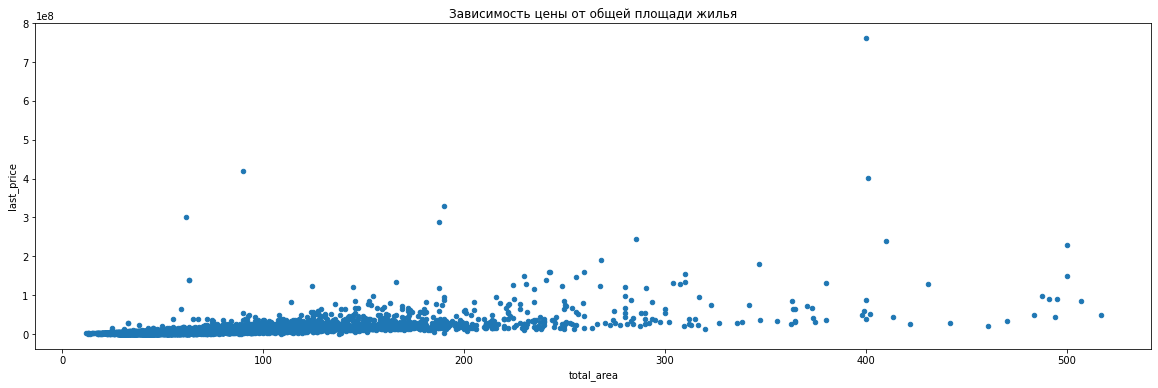

In [32]:
# Цена-Общая площадь:
df.plot(x='total_area', y='last_price', title='Зависимость цены от общей площади жилья',
        figsize=(20,6), kind='scatter');

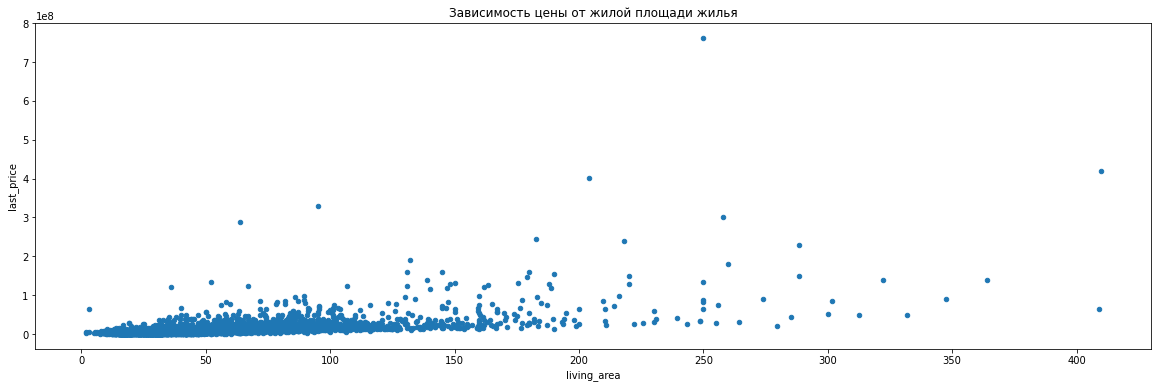

In [33]:
# Цена-Жилая площадь:
df.plot(x='living_area', y='last_price', title='Зависимость цены от жилой площади жилья',
        figsize=(20,6), kind='scatter');

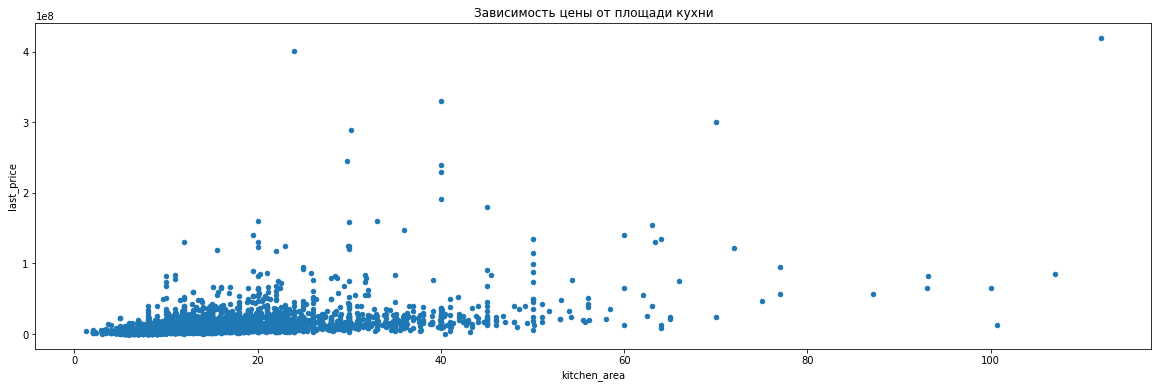

In [34]:
# Цена-площадь Кухни:
df.plot(x='kitchen_area', y='last_price', title='Зависимость цены от площади кухни',
        figsize=(20,6), kind='scatter');

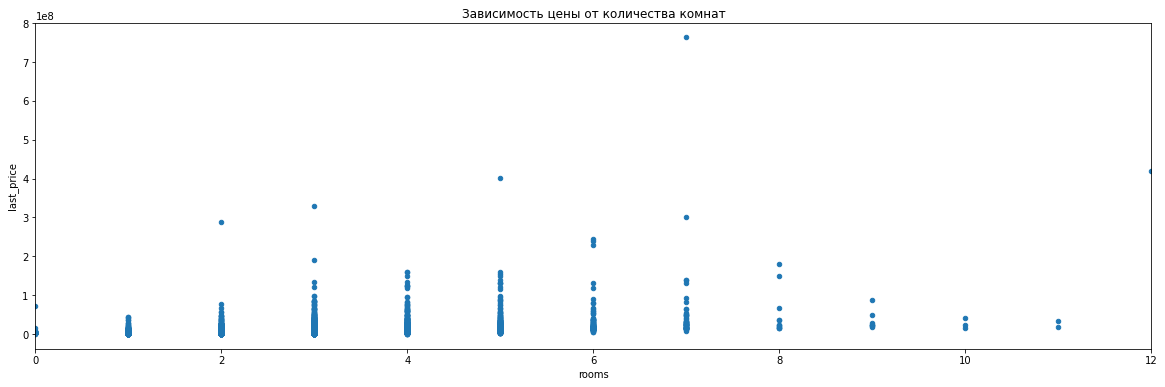

In [35]:
# Цена-Количество комнат:
df.plot(x='rooms', y='last_price', title='Зависимость цены от количества комнат',
        xlim=(0,12), figsize=(20,6), kind='scatter');

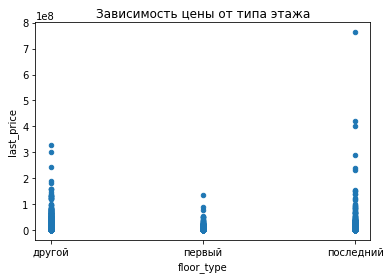

In [36]:
# Цена-тип этажа:
df.plot(x='floor_type', y='last_price', title='Зависимость цены от типа этажа', kind='scatter');

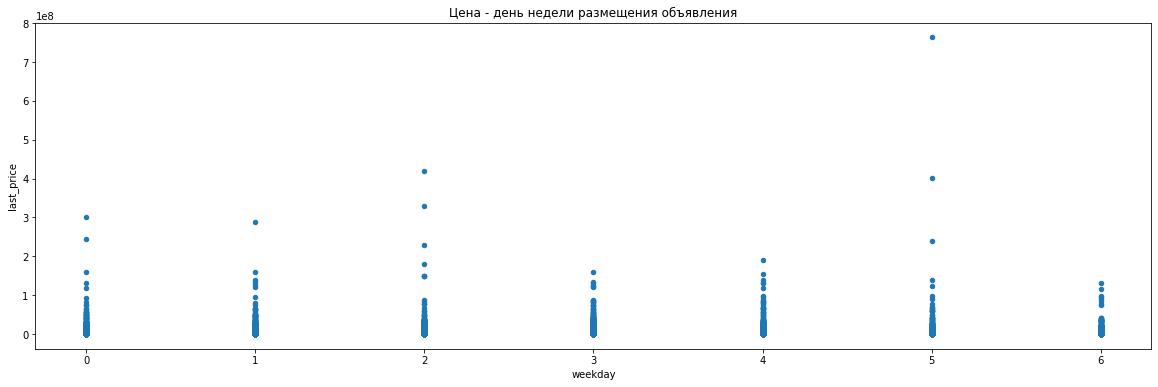

In [37]:
# Цена-день недели:
df.plot(x='weekday', y='last_price', title='Цена - день недели размещения объявления',
        kind='scatter', figsize=(20,6));

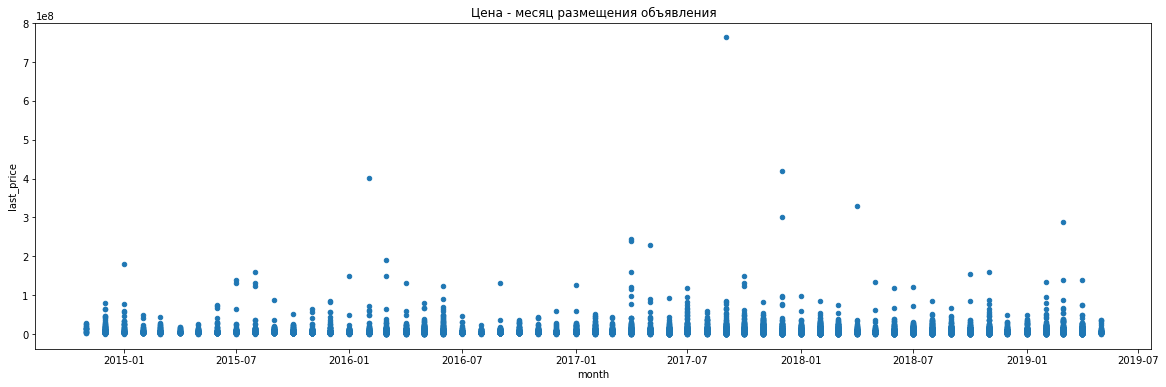

In [38]:
# Цена-месяц:
df.plot(x='month', y='last_price', title='Цена - месяц размещения объявления',
        kind='scatter', figsize=(20,6));

In [39]:
# Цена-год:
#df.plot(x='year', y='last_price', title='Цена - год размещения объявления', kind='scatter', figsize=(20,6));

In [40]:
# Год-Общая площадь квартир:
#df.plot(x='total_area', y='year', title='Зависимость общей площади продаваемого жилья от года', kind='scatter', figsize=(20,6));

- Цена-общая площадь. Корреляция прослеживается. При чём примерно до 120 м2 график плотный, а далее рассеивается, и при увеличении площади - цена растёт незначительно.
- Цена-жилая площадь. То же самое. Корреляция прослеживается. Примерно до 100 м2 график плотный, а далее рассеивается.
- Цена-площадь кухни. То же самое. Корреляция прослеживается. Примерно до 20 м2 график плотный, а далее рассеивается.
- Цена-количество комнат. Корреляция явная, до 4 комнат. Далее связи не наблюдается.
- Цена-этаж квартиры. Цены на средних этажах - выше, чем на первом, либо последнем. Цены на первом этаже - ниже, чем на последнем, либо на средних этажах.
- Цена-день недели размещения. Явной связи не прослеживается.
- Цена-месяц размещения. Явной связи не прослеживается.
- Цена-год. До 2017 года наблюдалась прямая связь (рост цены). После 2017 года пошёл спад. Но из диаграммы рассеяния "общая площадь жилья - год" видна точно такая-же взаимосвязь: до 2017 года площадь продаваемого жилья росла, а после начала снижаться. А стоят квартиры меньшей площади дешевле.

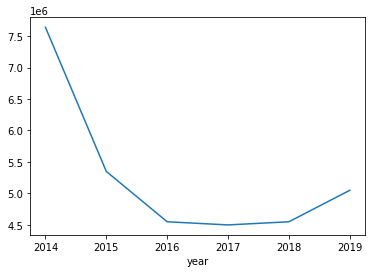

In [41]:
df.groupby('year')['last_price'].median().plot();

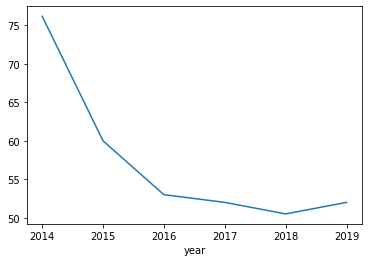

In [42]:
df.groupby('year')['total_area'].median().plot();

In [43]:
# Подсчитаем среднюю цену 1м2 в 10 населённых пунктах с наибольшим числом объявлений
df_price = df.groupby('locality_name').agg({'one_square_price':['count', 'median']})
df_price.columns = ['count', 'median_price']
df_price['median_price'] = df_price['median_price'].astype(int)
print(df_price.sort_values(by='count', ascending=False).head(10))
print('Населённый пункт с самой высокой ценой м2:', df_price['median_price'].idxmax(), df_price['median_price'].max(),'руб/м2')
print('Населённый пункт с самой низкой ценой м2:', df_price['median_price'].idxmin(), df_price['median_price'].min(),'руб/м2')

                 count  median_price
locality_name                       
Санкт-Петербург  15721        104761
Мурино             590         86175
Кудрово            472         95628
Шушары             440         76876
Всеволожск         398         65789
Пушкин             369        100000
Колпино            338         74723
Парголово          327         91642
Гатчина            307         67796
Выборг             237         58158
Населённый пункт с самой высокой ценой м2: Санкт-Петербург 104761 руб/м2
Населённый пункт с самой низкой ценой м2: Старополье 11000 руб/м2


In [44]:
# Рассчитаем среднюю стоимость 2-х комнатной квартиры в Санкт-Петербурге, на расстоянии 2км. от центра:
price_centre = df.loc[(df['locality_name']=='Санкт-Петербург') & (df['distance_center_km'] < 0.4) & 
                      (df['rooms'] == 2)]['one_square_price'].median()
# И то же самое - для квартир на расстоянии 258км. от центра:
price_suburb = df.loc[(df['locality_name']=='Санкт-Петербург') & (df['distance_center_km'] > 25.8) &
                      (df['rooms'] == 2)]['one_square_price'].median()
# Средняя стоимость одного километра:
print('Средняя стоимость 1 километра в Санкт-Петербурге:', int((price_centre - price_suburb) / 25.4),
      'рублей за 1м2')

Средняя стоимость 1 километра в Санкт-Петербурге: 12160 рублей за 1м2


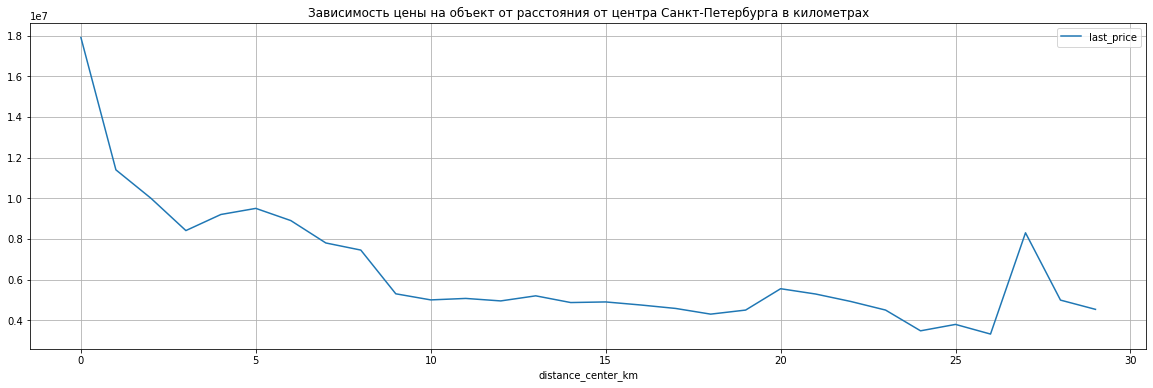

In [46]:
df[df['locality_name'] == 'Санкт-Петербург'].pivot_table(
    index='distance_center_km', values='last_price',aggfunc='median'
).plot(figsize=(20,6),
       title='Зависимость цены на объект от расстояния от центра Санкт-Петербурга в километрах', grid = True);

### Общий вывод

В процессе проведённого исследования объявлений сервиса "Яндекс.Недвижимость" по продаже квартир в Ленинградскиий области за 2014-2019 годы, мы:
1) Выполнили предобработку данных (избавились от пропусков, дубликатов, выявили аномалии, преобразовали типы данных)

2) Добавили в таблицу новые данные с недостающими параметрами: цена 1м2, день недели, месяц и год публикации объявления, тип этажа квартиры и расстояние до центра города в км.

3) Провели исследовательский анализ данных: построили гистограммы распределения по всем основным параметрам жилья, проанализировали длительность продажи, построили матрицу корреляции и диаграммы рассеяния по всем основным признакам, провели анализ взаимосвязи расстояния от центра города и цены за м2.


В результате, можно сделать следующие выводы:
- из общей массы объявлений по продаже квартир, 11% из них находятся на первом этаже и 13% - на последнем
- большая доля квартир - находятся на 1-5 этаже, в пяти- и девяти-этажных зданиях
- популярная площадь квартиры: 27-63м2 с пиком популярности на 43-45м2
- по жилой площади лидеры 18м2, за ними идут 30м2 квартиры
- самая многочисленная группа квартир имеет площадь кухни 9м2, за ней идёт кухня 6м2
- лидируют одно-, двух- и трёх-комнатные квартиры
- высота потолков в основном 2,4...2,7 метра
- существуют объявления по продаже жилья с количеством комнат до 19 шт. и с высотой потолков до 10 метров.
- продаваемое жильё располагается в основном на расстоянии 11-17км от центра, в 12-38 км. от Аэропорта, до ближайшего парка: 200-700 метров. Также присутствует достаточно квартир на удалении 3-6 км. от центра
- в ценовом диапазоне лидируют квартиры за 2,5-6 миллионов рублей. В Санкт-Петербурге - самая высокая средняя цена за 1м2 в регионе: 105 тыс.руб. Сразу за ним идёт г. Пушкин с ценой 100 тыс.руб/м2. Самое дешёвое жильё - в деревне "Ставрополье" - 11 тыс.руб/м2
- чем дальше жильё находится от центра - тем оно дешевле. Условно - каждый километр удаления от центра стоит 12 тыс.руб/м2. При чём на удалении до 10км. от центра  эта зависимость сильная, а далее её практически нет.
- на цену основное влияние оказывают: Общая и Жилая площадь, площадь Кухни, количество комнат, высота потолков, тип этажности, близость к центру города, наличие парков и водоёмов в радиусе трёх километров.
- на средних этажах квартиры дороже, чем на первом и последнем. Далее по цене идут квартиры на последних этажах, а самые дешёвые - на первом этаже.
- связи цены от дня недели либо месяца размещения объявления - не прослеживается.
- замечено, что с 2014 по 2017 годы росла общая площадь продаваемых квартир, а затем она начала снижаться.
- в среднем квартиры продаются от 1,5 до 8 месяцев, Медианное время продажи - 3 месяца. Быстрой считается продажа - в течение 1,5 месяцев, а долгой - 7,5 месяцев.
- по времени размещения объявлений о продаже квартир: активность наблюдается по вторникам и четвергам, а в выходные - минимальная активность.
- наблюдается сезонность с февраля по апрель. В мае - резкий спад активности. Далее, с июня по ноябрь - почти стабильный рост.